In [20]:
import argparse
import warnings
import os
import itertools
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import RGCNConv
from torch_geometric.loader import DataLoader, ClusterData, ClusterLoader, LinkNeighborLoader
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm, trange
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
hetero_data = torch.load('data/model/pyg/hetero_graph_v1.pt')

In [22]:
class RelGraphEmbed(nn.Module):
    r"""Embedding layer for featureless heterograph."""

    def __init__(self,
                 g,
                 embed_size,
                 embed_name='embed',
                 activation=None,
                 dropout=0.0):
        super().__init__()
        self.g = g
        self.embed_size = embed_size
        self.embed_name = embed_name
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

        # create weight embeddings for each node for each relation
        self.embeds = nn.ParameterDict()
        for ntype in g.node_types:
            embed = nn.Parameter(torch.Tensor(g[ntype].x.shape[0], self.embed_size))
            nn.init.xavier_uniform_(embed, gain=nn.init.calculate_gain('relu'))
            self.embeds[ntype] = embed

    def forward(self):
        return self.embeds

In [23]:
def transform_data(data, num_parts=128, batch_size=32, to_homo=True):
    '''_summary_

    Parameters
    ----------
    data : pyg 图数据
    num_parts : 邻接矩阵分割块数，默认128
    batch_size : 批量数，默认32

    此情况下train_loader包含4（=128/32）块

    Returns
    -------
    train_loader, val_data, test_data
    '''
    print('>>> 正在分割数据集并分批...')
    if to_homo == True:
        data = data.to_homogeneous()
    train_data, val_data, test_data = T.RandomLinkSplit(
        num_val=0.2,
        num_test=0.2,
        is_undirected=True,
        add_negative_train_samples=True,
        disjoint_train_ratio=0,
        #edge_types=hetero_data.metadata()[1][:int(
        #    0.5*len(hetero_data.metadata()[1]))],
        #rev_edge_types=hetero_data.metadata()[1][int(
        #    0.5*len(hetero_data.metadata()[1])):]
    )(data)
    # 训练集太大，分批量
    # tmp_cls = ClusterData(train_data, num_parts)
    # train_loader = ClusterLoader(tmp_cls, batch_size=batch_size)
    
    train_loader = LinkNeighborLoader(train_data, [512, 256, 128], batch_size=64)
    
    return train_loader, val_data, test_data

In [24]:
def negative_sample(data):
    # 从训练集中采样与正边相同数量的负边
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.size(1), method='sparse')
    # print(neg_edge_index.size(1))   # 3642条负边，即每次采样与训练集中正边数量一致的负边
    edge_label_index = torch.cat(
        [data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        data.edge_label,
        data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    return edge_label, edge_label_index

In [25]:
class RGCN_LP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, 
                 num_relations, node_types, init_sizes, dropout=0.5, reg_lambda=0.01):
        super(RGCN_LP, self).__init__()
        self.dropout = dropout
        self.reg_lambda = reg_lambda
        self.node_types = node_types
        self.conv1 = RGCNConv(in_channels, hidden_channels,
                              num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels,
                              num_relations=num_relations)
        self.lins = torch.nn.ModuleList()
        for i in range(len(node_types)):
            lin = nn.Linear(init_sizes[i], in_channels)
            self.lins.append(lin)

        self.fc = nn.Sequential(
            nn.Linear(2 * out_channels, 1),
            nn.Sigmoid()
        )

    def trans_dimensions(self, xs):
        res = []
        for x, lin in zip(xs, self.lins):
            res.append(lin(x))
        return torch.cat(res, dim=0)

    def encode(self, data):
        x = [data.x[data.node_type == node_type] for node_type in self.node_types]
        x = self.trans_dimensions(x)
        edge_index, edge_type = data.edge_index, data.edge_type
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x

    def decode(self, z, index):
        src = z[index[0]]
        dst = z[index[1]]
        x = torch.cat([src, dst], dim=-1)
        x = self.fc(x)
        return x

    def forward(self, data, index):
        z = self.encode(data)
        z = self.decode(z, index)
        return z
    
    def l2_regularization(self):
        l2_reg = torch.tensor(0.0, device=device)
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        return self.reg_lambda * l2_reg

In [26]:
def get_metrics(out, label):
    auc = roc_auc_score(label.cpu().numpy(), out.cpu().numpy())
    ap = average_precision_score(label.cpu().numpy(), out.cpu().numpy())
    return auc, ap

def prepare_data(random_feat, data, random_feat_dim, feat_flag, data_path='data/model/pyg/'):
    if random_feat and os.path.exists(f'{data_path}splited_data_{feat_flag}.pt'):
        print('>>> 读取已有可训练随机编码...')
        train_loader, val_data, test_data = torch.load(f'{data_path}splited_data_{feat_flag}.pt').dataset
        embed_layer = None
    elif random_feat:
        print('>>> 为节点分配可训练随机编码...')
        embed_layer = RelGraphEmbed(data, random_feat_dim)
        for node_type in data.node_types:
            data[node_type].x = embed_layer()[node_type]
        train_loader, val_data, test_data = transform_data(data, to_homo=True)
        torch.save(DataLoader([train_loader, val_data, test_data]),
                   f'{data_path}splited_data_{feat_flag}.pt')
    elif not random_feat and os.path.exists(f'{data_path}splited_data_{feat_flag}.pt'):  # 真实特征
        print('>>> 读取已有数据...')
        train_loader, val_data, test_data = torch.load(f'{data_path}splited_data_{feat_flag}.pt').dataset
        embed_layer = None
    elif not random_feat:
        train_loader, val_data, test_data = transform_data(data, to_homo=True)
        torch.save(DataLoader([train_loader, val_data, test_data]),
                   f'{data_path}splited_data_{feat_flag}.pt')
        embed_layer = None
    print('数据准备完毕!')
    return train_loader, val_data, test_data, embed_layer

In [27]:
def train(data, random_feat=False, random_feat_dim=32, in_feats=16,
          hidden_feats=32, out_channels=16, epochs=40, dropout=0, reg=0.01, lr=0.001):
    # ---------- 参数 ------------
    feat_flag = 'Random_feat' if random_feat else 'Real_feat'
    train_loader, val_data, test_data, embed_layer = prepare_data(random_feat, data, random_feat_dim, feat_flag)
    tmp_train_data = next(iter(train_loader))  # 采一个样例便于初始化
    init_sizes = [tmp_train_data.x[tmp_train_data.node_type==node_type].shape[-1]
                  for node_type in tmp_train_data.node_type.unique()]
    num_relations = len(data.edge_types)  # 边关系类型，变同质图之后只有两种类型
    new_node_types = val_data.node_type.unique()  # 变同质图后，会被标记为0（客户）和1（商品）
    model = RGCN_LP(in_feats, hidden_feats, out_channels, num_relations,
                    new_node_types, init_sizes, dropout, reg).to(device)
    if embed_layer:
        all_params = itertools.chain(model.parameters(), embed_layer.parameters())
    else:
        all_params = itertools.chain(model.parameters())
        
    optimizer = torch.optim.Adam(all_params, lr=lr)
    criterion = torch.nn.BCELoss().to(device)
    summary = {'train_loss': [], 'val_loss': [],
               'test_auc': [], 'test_avg_pre': []}
    # epoch_count = 0
    model.train()  # 设定模型为可训练
    val_data.to(device)
    test_data.to(device)
    
    # ---------- 训练 ----------
    print('开始训练...')
    with tqdm(total=epochs, leave=False,) as pbar:
        for epoch in range(epochs):
            for train_batch in train_loader:
                train_batch.to(device)
                optimizer.zero_grad()
                # edge_label, edge_label_index = negative_sample(train_batch)
                out = model(train_batch, train_batch.edge_index).view(-1)
                loss = criterion(out, train_batch.edge_label) + model.l2_regularization()
                loss.backward(retain_graph=True)
                optimizer.step()
            # validation
            val_loss, test_auc, test_ap = test(model, val_data, test_data)
            summary['train_loss'].append(loss.item())
            summary['val_loss'].append(val_loss)
            summary['test_auc'].append(test_auc)
            summary['test_avg_pre'].append(test_ap)
            pbar.set_postfix({'train_loss': round(loss.item(), 2),
                              'val_loss/min': '{:.2f}/{:.2f}'.format(val_loss, min(summary['val_loss'])), 
                              'test_auc': test_auc, 
                              'test_ap': test_ap})
            pbar.update(1)
    print('训练完毕，保存数据...')
    summary = pd.DataFrame(summary)
    summary.to_csv(f'data/result/pyg/pyg_link_pre_{feat_flag}.csv', 
                   index=False, encoding='utf-8-sig')
    sns.lineplot(summary)
    return summary


@torch.no_grad()
def test(model, val_data, test_data):
    model.eval()  # 设定模型不可训练
    # cal val loss
    criterion = torch.nn.BCELoss().to(device)
    out = model(val_data, val_data.edge_label_index).view(-1)
    val_loss = criterion(out, val_data.edge_label)
    # cal metrics
    out = model(test_data, test_data.edge_label_index).view(-1)
    auc, ap = get_metrics(out, test_data.edge_label)
    model.train()
    return val_loss.item(), auc, ap

In [28]:
# 定义参数
in_feats = 16  # 直接指定即可，RGCN中有一个线性层转化输出统一到此维度
hidden_feats = 32  # 隐藏层，直接指定即可
out_channels = 16  # 输出层，直接指定，最终输出的解码器的输入维度是 2*out_channels

In [29]:
summary = train(hetero_data, random_feat=True, random_feat_dim=32, 
                in_feats=in_feats, hidden_feats=hidden_feats, out_channels=out_channels, 
                epochs=30, dropout=0, reg=0.02, lr=0.05)

>>> 读取已有可训练随机编码...


RuntimeError: PytorchStreamReader failed locating file data/9: file not found

<Axes: >

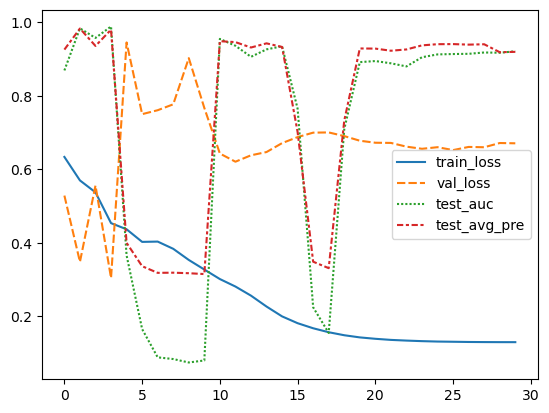

In [64]:
sns.lineplot(summary)